# Data Processing

In [10]:
# import datetime
# import pandas as pd
# from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from selenium.common.exceptions import TimeoutException

# # We will be using code from https://colab.research.google.com/drive/1STvYH8iwru1xHe3uT1oUPjwPN8Qgv7mP?authuser=1#scrollTo=5vYU1bQQIid1
# # for the gathering 2024 season odds
# import time


# month = {
#     "January": 1,
#     "February": 2,
#     "March": 3,
#     "April": 4,
#     "May": 5,
#     "June": 6,
#     "July": 7,
#     "August": 8,
#     "September": 9,
#     "October": 10,
#     "November": 11,
#     "December": 12
# }

# referenceTable = {
#     "NY" : "NYK",
#     "UTAH" : "UTA",
#     "NO" : "NOP",
#     "SA" : "SAS",
#     "GS" : "GSW",
#     "WSH" : "WAS"
# }

# # Define retry function
# def get_with_retry(driver, url, max_retries=8, delay=10):
#     retries = 0
#     while retries < max_retries:
#         try:
#             driver.get(url)
#             return driver.page_source
#         except TimeoutException as e:
#             print(f"Timeout error occurred: {e}. Retrying...")
#         except Exception as e:
#             print(f"An error occurred: {e}. Retrying...")
        
#         retries += 1
#         time.sleep(delay)  # Wait for a short delay before retrying
    
#     print("Max retries reached. Unable to fetch data.")
#     return None

# def getGames():
#     games = []
#     checker = False

#     # gameid ranges for the 2024 nba season
#     # 401584689 (start gameid)
#     #401585704+1 (3-30-2024 gamid)
#     # 401585825 (end gameid)
#     for i in range (401584689, 401585825+1):


#         url= "https://www.espn.com/nba/boxscore/_/gameId/" + str(i)

#         # chrome_options = Options()
#         options = webdriver.ChromeOptions()
#         options.add_argument("--window-size=1920,1080")
#         options.add_argument("--headless")
#         options.add_argument("--disable-gpu")
#         options.add_argument(
#             "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36")
#         driver = webdriver.Chrome(executable_path='C:/Drivers/chromedriver.exe', options=options)

#         content = get_with_retry(driver, url)
#         if content is None:
#             continue

#         content = content.encode('utf-8').strip()
#         soup = BeautifulSoup(content,"html.parser")

#         g = getOdds(soup)

#         # this will print out the gameId ranges idk why but it does
#         if g != None:
#             if not checker:
#                 print('[', i)
#             games.append(g)
#             checker = True
#         elif checker:
#             print(i - 1, ']')
#             checker = False
#         driver.quit()

#     return games


# def getOdds(soup):
#     results = soup.find(class_="n8 GameInfo__Meta")
#     # Return none if page is empty
#     if results is None:
#         return None
#     # Gets date of game
#     date_list = results.text.split(" ")
#     date = datetime.datetime(int(date_list[4][:4]), int(month[date_list[2]]), int(date_list[3][:-1]))
#     date_string = date.strftime("%Y-%m-%d")

#     # Gets name of teams that played
#     results = soup.find_all(class_="ScoreCell__Truncate Gamestrip__Truncate h4 clr-gray-01")
#     away = results[0].find('a', href=True)['href'].split("/")[-2].upper()
#     home = results[1].find('a', href=True)['href'].split("/")[-2].upper()

#     # Changes team initials if needed for conversion
#     a = referenceTable.get(away)
#     if a is None:
#         a = away
#     h = referenceTable.get(home)
#     if h is None:
#         h = home

#     results = soup.find(class_="betting-details-with-logo")
#     # Return none if game was not played
#     if results is not None:
#         odds = results.find_all('div')
#         line = odds[0].text.split(' ')
#         overunder = odds[1].text.split(' ')
#     else:
#         return None

#     # Gets line for game, 0 point spread if even
#     if len(line) < 3:
#         l = [home, "0"]
#     else:
#         l = line[1:]

#     # Gets favorite of game
#     fav = referenceTable.get(l[0])
#     if fav is None:
#         fav = l[0]

#     line_string = fav + " " + l[1]

#     # Formats overunder
#     if float(overunder[1]) % 1 == 0:
#         o = int(overunder[1])
#     else:
#         o = float(overunder[1])

#     return ([date_string, a, h, fav, l[1], o])



# def getOddsToCsv():
#     games = getGames()
#     games_lines_df = pd.DataFrame(games)
#     games_lines_df = games_lines_df.rename(columns={0: 'Date', 1: 'Away', 2: 'Home', 3: 'Favorite', 4: 'Line', 5: 'Over/Under'})
#     games_lines_df.to_csv('2024_Final_Season_Odds.csv')

# getOddsToCsv()

# Models
Below we will have 4 different models which will help us predict wins and loses of nba games

### Logistic Regression Model
Run this model using data from 2012-2024 without using rolling averages then we incorporate a 10 day rolling average to predict wins/loses

In [11]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np


df = pd.read_csv('../data/season-data/2012_to_2024_data.csv')

df['date_temp'] = pd.to_datetime(df['date'])
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
df.drop(columns=['date_temp'], inplace=True)
df = df.sort_values('date')

del df['mp']
del df['mp_opp']

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

df = df.groupby('team', group_keys=False).apply(add_target)

df['target'][pd.isnull(df['target'])] = 2
# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]
nulls
# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns

df = df[valid_columns].copy()

# model time 
lr = LogisticRegression(random_state= 0, max_iter=2000)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward', cv=split)

removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

sfs.fit(df[selected_columns], df['target'])
predictors = list(selected_columns[sfs.get_support()])


def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    seasons = sorted(data['season'].unique())

    for i in range(start, len(seasons), step):
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]

        model.fit(train[predictors], train['target'])
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']

        all_predictions.append(combined)
    
    return pd.concat(all_predictions)

predictions = backtest(df, lr, predictors)
accruacy_lr = accuracy_score(predictions['actual'], predictions['prediction'])
print(accruacy_lr)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\1605032853.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)
C:\Users\giova\AppData\Local\Temp\ipykernel_11360\1605032853.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column 

0.5353892027620841


In [12]:
### Incorporating the 10 day rolling averages
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]
df_rolling

def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    # print(numeric_cols)
    rolling = numeric_cols.rolling(10).mean()
    return rolling

df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
df_rolling

rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1)
df

df= df.dropna()
df = df.copy()
df

def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# TODO add if a team is playing home or not
# df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")

df

df = df.copy()
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])
full


full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
removed_columns

selected_columns = full.columns[~full.columns.isin(removed_columns)]
# selected_columns
sfs.fit(full[selected_columns], full['target'])

predictors = list(selected_columns[sfs.get_support()])
predictors

predictions = backtest(full, lr, predictors)

accuracy_lr_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_lr_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\2497240628.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_11360\2497240628.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:

0.6132721091438915


### XG-Boost Model

In [13]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np


df = pd.read_csv('../data/season-data/2012_to_2024_data.csv')

df['date_temp'] = pd.to_datetime(df['date'])
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
df.drop(columns=['date_temp'], inplace=True)
df = df.sort_values('date')

del df['mp']
del df['mp_opp']

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

df = df.groupby('team', group_keys=False).apply(add_target)

# df['target'][pd.isnull(df['target'])] = 2

df['target'] = df['target'].fillna(0).astype(int)
# Ensure the target has only 0 and 1
df['target'] = df['target'].apply(lambda x: 1 if x == 1 else 0)

# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]
nulls
# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns

df = df[valid_columns].copy()
# model time 
xgboost = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(xgboost, n_features_to_select=10, direction='forward', cv=split)

removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

sfs.fit(df[selected_columns], df['target'])
predictors = list(selected_columns[sfs.get_support()])


def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    seasons = sorted(data['season'].unique())

    for i in range(start, len(seasons), step):
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]

        model.fit(train[predictors], train['target'])
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']

        all_predictions.append(combined)
    
    return pd.concat(all_predictions)

predictions = backtest(df, xgboost, predictors)
accuracy_xgboost = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_xgboost)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\2285855508.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)


0.5338983050847458


In [14]:
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]
df_rolling

def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    # print(numeric_cols)
    rolling = numeric_cols.rolling(10).mean()
    return rolling

df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
df_rolling

rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1)
df

df= df.dropna()
df = df.copy()
df


def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# TODO add if a team is playing home or not
# df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")

df

df = df.copy()
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])
full

full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
removed_columns

selected_columns = full.columns[~full.columns.isin(removed_columns)]
# selected_columns
sfs.fit(full[selected_columns], full['target'])

predictions = backtest(full, xgboost, predictors)

accuracy_xgboost_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_xgboost_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\3618422774.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_11360\3618422774.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:

0.5349905073071659


### Ridge Regression Model

In [15]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

df = pd.read_csv('../data/season-data/2012_to_2023_data.csv')
# Convert date column to datetime type
df['date_temp'] = pd.to_datetime(df['date'])

# Add a season column based on the date
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
df.drop(columns=['date_temp'], inplace=True)
df = df.sort_values('date')
df

# delete unnecessary columns
del df['mp']
del df['mp_opp']
df

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

df = df.groupby('team', group_keys=False).apply(add_target)
df[df['team'] == 'NYK'].sort_values('date')

df['target'][pd.isnull(df['target'])] = 2
df['target'].value_counts()
# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]
nulls

# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns

df = df[valid_columns].copy()
df

rr = RidgeClassifier(alpha=1.0)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select=10, direction='forward', cv=split)

removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])
df

sfs.fit(df[selected_columns], df['target'])
predictors = list(selected_columns[sfs.get_support()])
predictors

def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    seasons = sorted(data['season'].unique())

    for i in range(start, len(seasons), step):
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]

        model.fit(train[predictors], train['target'])
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']

        all_predictions.append(combined)
    
    return pd.concat(all_predictions)

accuracy_rr = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_rr)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\2581725170.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)
C:\Users\giova\AppData\Local\Temp\ipykernel_11360\2581725170.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column 

0.5349905073071659


In [16]:
## Rolling averages code
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]
df_rolling

def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    # print(numeric_cols)
    numeric_cols = numeric_cols.drop(columns=['season'])
    rolling = numeric_cols.rolling(10).mean()
    return rolling

df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
df_rolling

rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1)
df

df= df.dropna()
df = df.copy()
df

def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# TODO add if a team is playing home or not
# df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")

df = df.copy()
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])
full

full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
removed_columns

selected_columns = full.columns[~full.columns.isin(removed_columns)]
# selected_columns
sfs.fit(full[selected_columns], full['target'])

predictors = list(selected_columns[sfs.get_support()])
predictors

predictions = backtest(full, rr, predictors)

accuracy_rr_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_rr_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_11360\838024650.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_11360\838024650.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:\U

0.6177404386264836


### Neural Network

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


# Select features and target
X = full[selected_columns]
y = full['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model configuration
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='leaky_relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='leaky_relu'),
    tf.keras.layers.Dense(4, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='SGD',
              loss='MSE',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
loss, accuracy_nn = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_nn:.2f}")

c:\Users\giova\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,153 (16.22 KB)

 Trainable params: 4,153 (16.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5091 - loss: 0.2564 - val_accuracy: 0.5453 - val_loss: 0.2462
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.5664 - loss: 0.2435 - val_accuracy: 0.5657 - val_loss: 0.2419
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.5805 - loss: 0.2396 - val_accuracy: 0.5759 - val_loss: 0.2397
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.5900 - loss: 0.2377 - val_accuracy: 0.5886 - val_loss: 0.2381
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.5935 - loss: 0.2369 - val_accuracy: 0.5928 - val_loss: 0.2372
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6001 - loss: 0.2348 - val_accuracy: 0.5975 - val_loss: 0.2364
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6093 - loss: 0.2331 - val_accuracy: 0.5995 - val_loss: 0.2357
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.6091 - loss: 0.2334 - va

### Plots
First we are going to plot the models accuracies without rolling averages

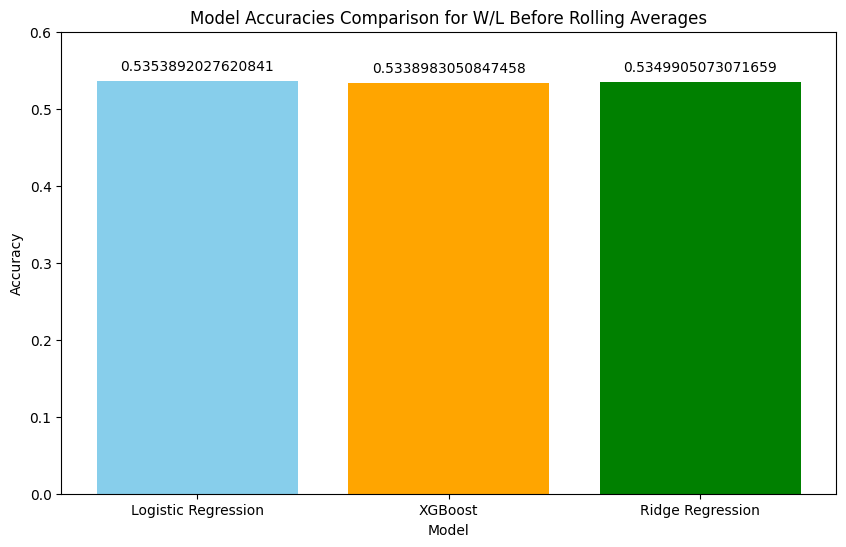

In [27]:
import matplotlib.pyplot as plt

model_accuracies = {
    'Logistic Regression': accruacy_lr,
    'XGBoost': accuracy_xgboost,
    'Ridge Regression': accuracy_rr,
}

model_names = list(model_accuracies.keys())
accuracy_values = list(model_accuracies.values())

colors = ['skyblue', 'orange', 'green']
# Create a bar graph with matplotlib
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(model_names, accuracy_values, color=colors)  # Set bar color
plt.title('Model Accuracies Comparison for W/L Before Rolling Averages')  # Title for the plot
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.ylim(0, .6)  # Set y-axis limits to represent accuracy as a percentage

# Add text labels for the actual accuracy values on top of each bar without rounding
for bar in bars:
    yval = bar.get_height()  # Get the height (accuracy) of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Position text at the center of the bar, slightly above it
             yval,  # Use the exact float value for accuracy
             ha='center', va='bottom')  # Horizontal alignment to center, vertical alignment to bottom

plt.show()  # Display the plot

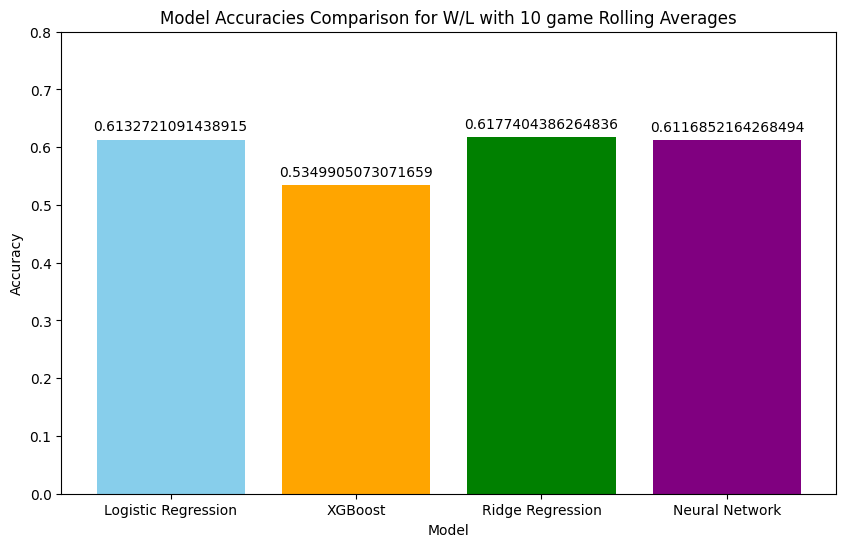

In [29]:
import matplotlib.pyplot as plt

model_accuracies = {
    'Logistic Regression': accuracy_lr_rolling,
    'XGBoost': accuracy_xgboost_rolling,
    'Ridge Regression': accuracy_rr_rolling,
    'Neural Network': accuracy_nn,
}

model_names = list(model_accuracies.keys())
accuracy_values = list(model_accuracies.values())

colors = ['skyblue', 'orange', 'green', 'purple']
# Create a bar graph with matplotlib
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(model_names, accuracy_values, color=colors)  # Set bar color
plt.title('Model Accuracies Comparison for W/L with 10 game Rolling Averages')  # Title for the plot
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.ylim(0, .8)  # Set y-axis limits to represent accuracy as a percentage

# Add text labels for the actual accuracy values on top of each bar without rounding
for bar in bars:
    yval = bar.get_height()  # Get the height (accuracy) of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Position text at the center of the bar, slightly above it
             yval,  # Use the exact float value for accuracy
             ha='center', va='bottom')  # Horizontal alignment to center, vertical alignment to bottom

plt.show()  # Display the plot